In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#matplotlib inline

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("bioAI.mplstyle")
sys.path.append("../src") if "../src" not in sys.path else None 

from Experiment import Experiment
from methods import PCA_UMAP
from stats import grid_score_masks
from plotting_functions import *

import utils

/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1086: NumbaD

In [3]:
# Load ratemaps and module indices
base_path = "../"#"/mnt/WD12TB-HDD"
experiment = utils.load_experiment(base_path, "gg-new")
ratemaps = utils.load_ratemaps(experiment)

# ---> select cells by manifold (gardner et al.) <---
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_new.npz")
module_indices = module_indices['C0_from_env_2']

Experiment <gg-new> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
g = np.reshape(ratemaps, (*ratemaps.shape[:2],-1)) # flatten bin dims; (Nenv, Ng, nbins)
g = np.transpose(g, (0, 2, 1)) # reshape so cell dim is last
g = g[..., module_indices] # mask out torus units
g.shape

(3, 4096, 375)

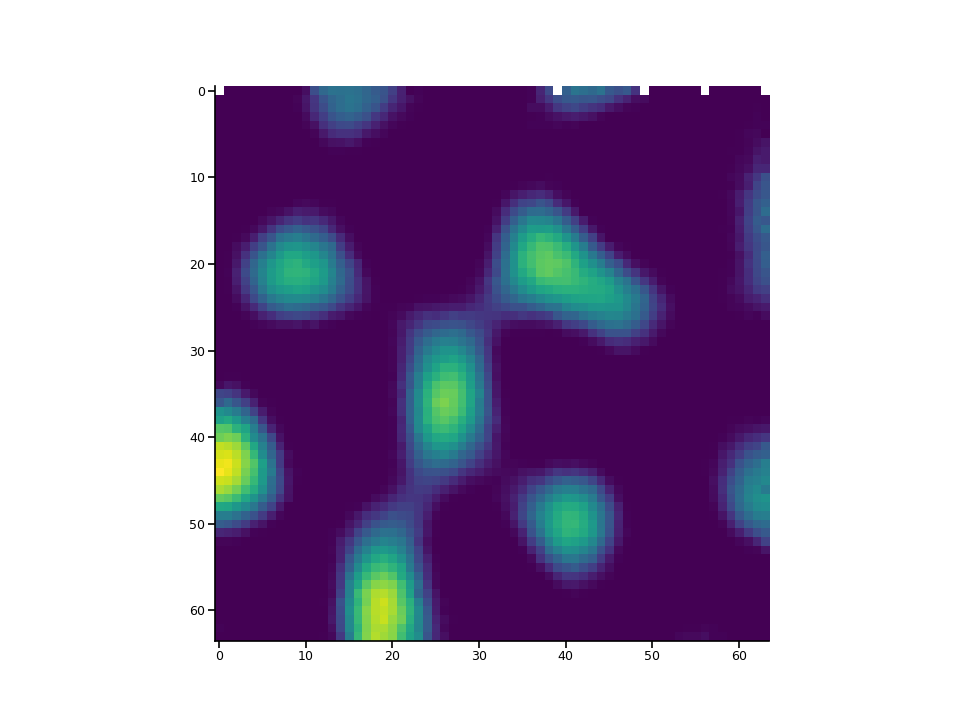

In [5]:
plt.imshow(ratemaps[0, module_indices[0]])

In [6]:
# mask out NaN bins; a bin is NaN if all activities are NaN
g = [gs[np.all(~np.isnan(gs), axis = -1)] for gs in g]

In [7]:
pca_fits = []
umap_fits = []
for env_i in range(len(g)):
    pca_fit, umap_fit = PCA_UMAP(g[env_i])
    pca_fits.append(pca_fit)
    umap_fits.append(umap_fit)

/Users/m/Documents/jobb/phd/emergent-grid-cells/notebooks/../src/plotting_functions.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=ncols, nrows=nrows, subplot_kw={"projection": "3d"}, **kwargs)


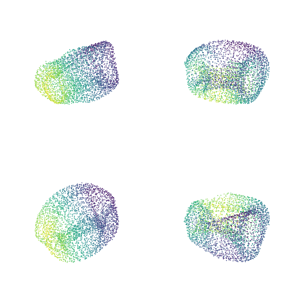

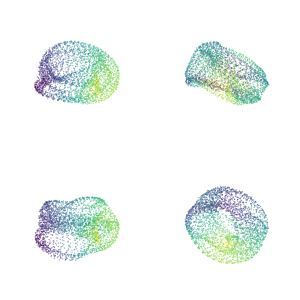

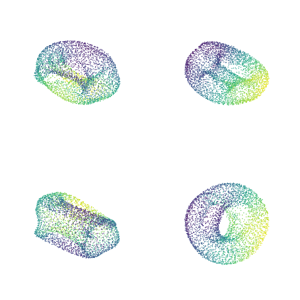

In [17]:
for env_i in range(len(g)):
    inds, _,_ = utils.downsample_pointcloud(pca_fits[env_i], k = 30, num_sample = 3250, metric = 'cosine')
    fig,axs = scatter3d(umap_fits[env_i][inds],pca_fits[env_i][inds][:,0],nrows=2,ncols=2,azim_elev_title=False, 
                        s = 0.1, alpha = 0.5, dpi=300, figsize = (1,1))
    #axs[-1,-1].set_title('end')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.0, hspace = 0.0)

    #fig.savefig(experiment.paths['experiment'] / f'plots/torei_{selection_process_name}_{env_i}')

In [11]:
# colors for insckape collection
# 0: 229 235 241
# 1: 250 248 231
# 2: 251 241 242

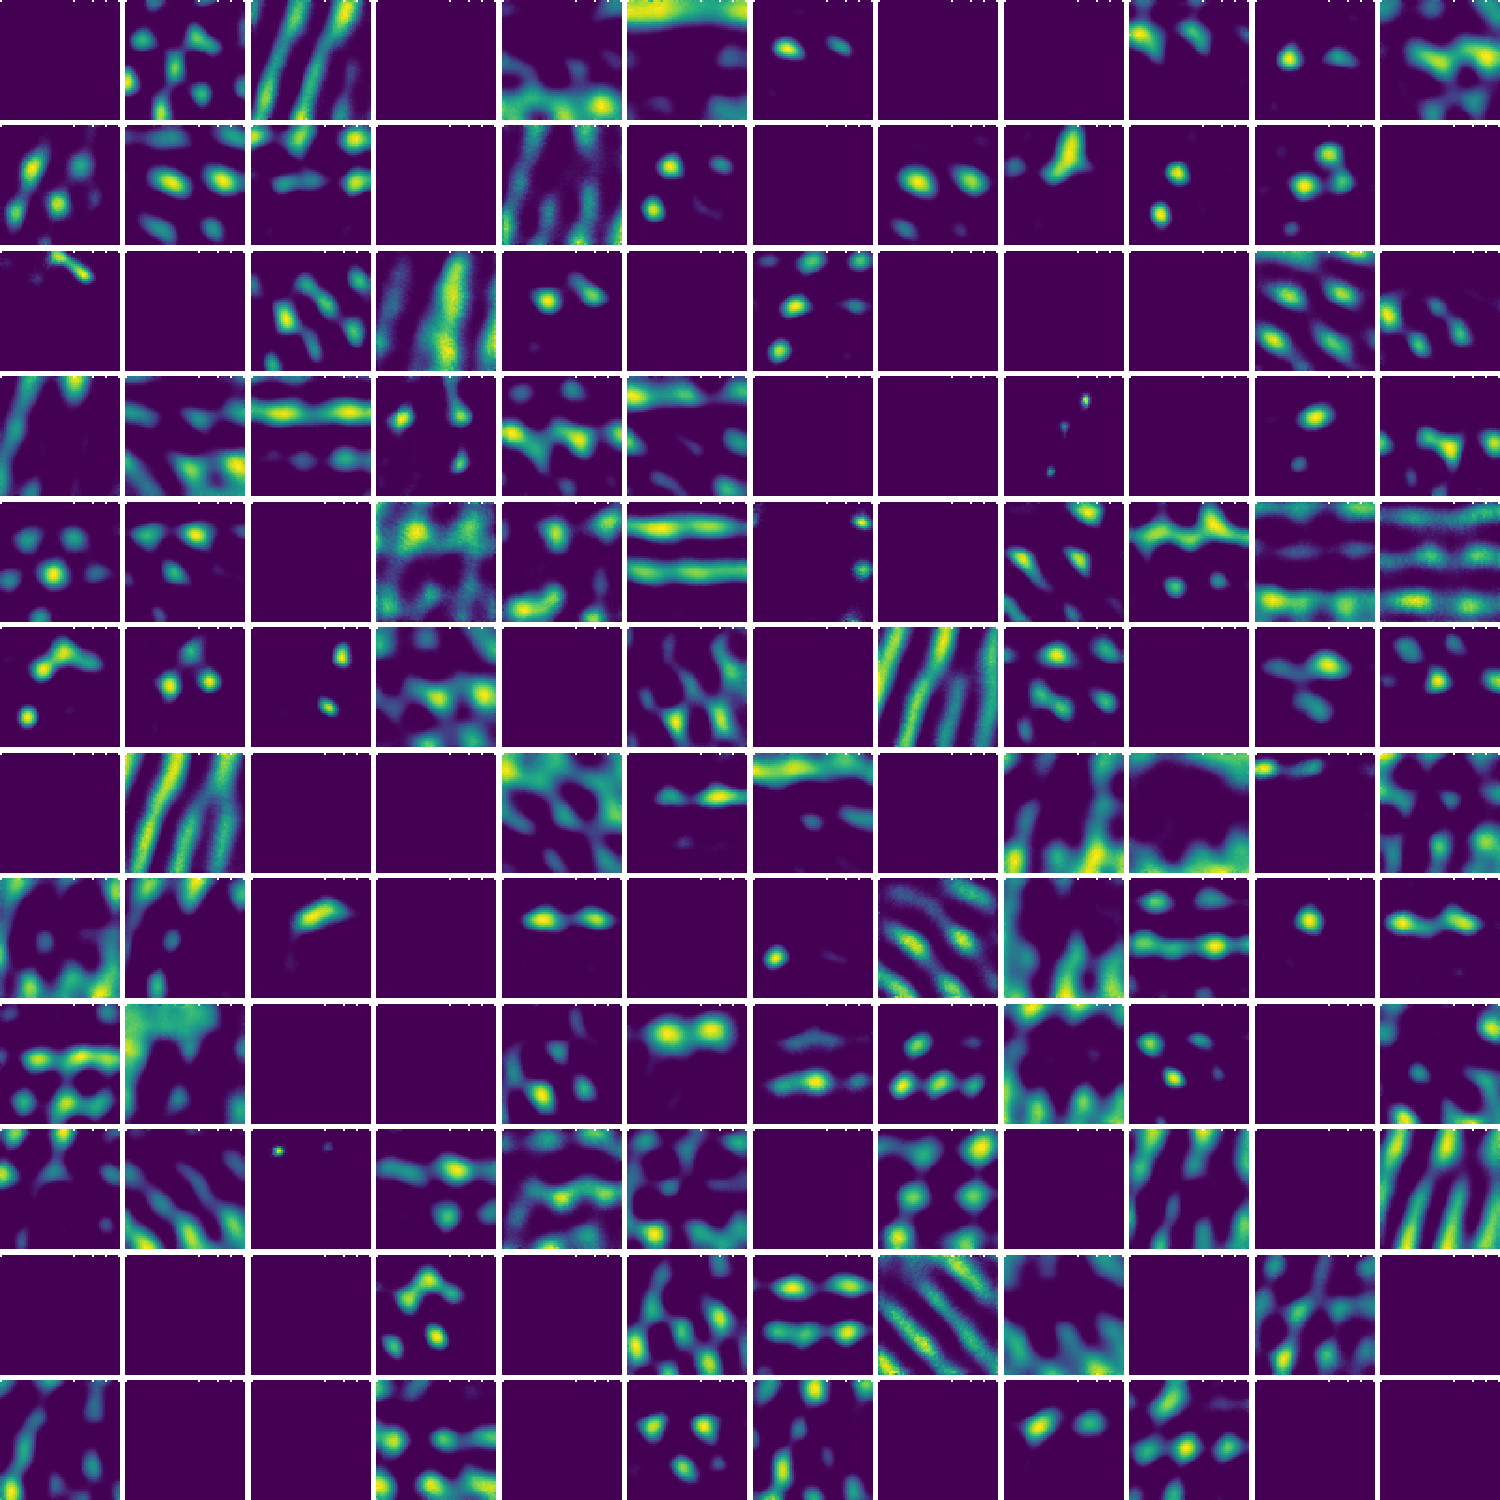

In [14]:
# plot some selected index ratemaps
fig, ax = plt.subplots(12,12, figsize = (10,10))
count = -1
for i in range(12):
    for j in range(12):
        count +=1 
        ax[i,j].imshow(ratemaps[0][count])
        ax[i,j].axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.05, hspace = 0.05)